# FOR THE BOARD

In [ ]:
import machine
from machine import Pin
from machine import ADC, SPI
import time
from machine import Timer
import gc
from machine import freq
from lib.utils import connect_wifi
from lib.requests import MicroWebCli as requests
import ujson as json

freq(240000000)
adc = ADC(Pin(33))
adc.atten(machine.ADC.ATTN_11DB)
adc.width(machine.ADC.WIDTH_12BIT)
adcread = adc.read()

##################################################################################

DEFAULT_SPI_PARAMS = {
    "spi_num": 2,
    "sck": 18,
    "mosi": 23,
    "miso": 19,
    "output_amp_gain": 255,  # value between 0-255 controlling gain of output amplifier
}

get_param = lambda key: Pin(DEFAULT_SPI_PARAMS[key])
temp_spi_params = {key: get_param(key) for key in ["sck", "miso", "mosi"]}

spi = SPI(
    2,
    baudrate=10000000,
    polarity=0,
    phase=0,
    sck=Pin(18),
    mosi=Pin(23),
    miso=Pin(19),
)

# setting gain #

# data = bytearray([17, DEFAULT_SPI_PARAMS['output_amp_gain']])
data = bytearray([17,DEFAULT_SPI_PARAMS['output_amp_gain']])
# data = bytearray(100)
cs = machine.Pin(5, machine.Pin.OUT)

# have to turn GPIO 5 off before writing the gain

cs.off() 
spi.write(data)
cs.on() 

# will change lol
ssid = 'TP-Link_AP_4C04'
password = '63525465'
connect_wifi(ssid, password)

###############################################################################

adc_sample = []

# set for frequency the adc should be read and set the size of the array to send every t seconds 
pot_size = 256

def sample_callback(*args, **kwargs):
    global adc_sample
    if len(adc_sample) >= pot_size:
        # fifo
        del adc_sample[0]
        adc_sample.append(adc.read())
    else:
        adc_sample.append(adc.read())

sample_timer = Timer(0)
sample_timer.init(freq=pot_size, callback=sample_callback)

requests.JSONRequest("http://192.168.0.37:5001/message", {"message": "### LOOK AT 7 HZ ###"})
time.sleep(10)
    
#send 7hz data
for i in range(4):
    time.sleep(1)
    print(gc.mem_free())
    data = adc_sample
    toSend = {"7":data}
    print(toSend)
    requests.JSONRequest("http://192.168.0.37:5001/7hz", toSend)
    
requests.JSONRequest("http://192.168.0.37:5001/message", {"message": "### LOOK AT 10 HZ ###"})
time.sleep(10)

#send 10hz data
for i in range(4):
    time.sleep(1)
    print(gc.mem_free())
    data = adc_sample
    toSend = {"10":data}
    print(toSend)
    requests.JSONRequest("http://192.168.0.37:5001/10hz", toSend)

requests.JSONRequest("http://192.168.0.37:5001/message", {"message": "### LOOK AT 12 HZ ###"})
time.sleep(5)

#send 12hz data
for i in range(4):
    time.sleep(1)
    print(gc.mem_free())
    data = adc_sample
    toSend = {"12":data}
    print(toSend)
    requests.JSONRequest("http://192.168.0.37:5001/12hz", toSend)

requests.GETRequest("http://192.168.0.37:5001/isCalibrated")

while True:
    time.sleep(1)
    print(gc.mem_free())
    data = adc_sample
    toSend = {"raw_data":data}
    print(toSend)
    requests.JSONRequest("http://192.168.0.37:5001/decode", toSend)

# FOR THE PROCESSING

In [73]:
import numpy as np
from scipy import signal
from sklearn.model_selection import LeavePOut
import random
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP
from eeg_lib.utils import standardise
import matplotlib.pyplot as plt
import pandas as pd

def synth_x(f, Ns, noise_power=0.5, fs=256):
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80 

fc_lo = 4 # pass band lower freq
fc_hi = 32 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

def load_array_data_float(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [float(i) for i in data_file]
    return values

def average_every_n(values, size):
#     return np.array([sum(group) / size for group in zip(*[iter(values)]*size)])
    return values[::size]

def sos_filter_256(values):
    return signal.sosfilt(sos_ellip, values)
#     return signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values)

def process_data(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_256(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def prepare_data(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def prepare_data_OpenBCI(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data_OpenBCI(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def generate_train_test_idxs(data,no_train):
    lpo = LeavePOut(p=no_train)
    no_trials = data.shape[-1]
    return list(lpo.split(range(no_trials)))

def flatten(t):
    return [item for sublist in t for item in sublist]

def test_gcca_mset(data, data_idxs, freqs, fs, no_samples, number_runs=10):
    # Nf x Nc x Ns x Nt
    gcca = GCCA_SSVEP(freqs, fs, Nh=1)
    mset_cca = MsetCCA_SSVEP(freqs)
    gcca_total_acc = []
    mset_total_acc = []
    gcca_freq_acc = dict((key,[]) for key in freqs)
    mset_freq_acc = dict((key,[]) for key in freqs)

    for i in range(number_runs):
        # Nf x Nc x Ns x Nt
        train = data[:,:,:,data_idxs[i][1]]
        test = data[:,:,:,data_idxs[i][0]]

        gcca.fit(train)
        mset_cca.fit(train)
        
        for freq, value in enumerate(freqs):
            gcca_res = []
            mset_res = []
            #print("############################# Frequency:", value, " #############################")
            for test_idx in range(test.shape[-1]):
                test_now = test[freq, :, :, test_idx]
                
                gcca_decode = gcca.classify(test_now)
#                 print(gcca_decode)
                for key, prob in gcca_decode.items():
                    gcca_decode[key] = abs(prob)
                
                gcca_res.append(max(gcca_decode, key=gcca_decode.get))
                
                mset_decode = mset_cca.classify(test_now)
#                 print(mset_decode)
                mset_res.append(max(mset_decode, key=mset_decode.get))
            #print("GCCA accuracy {gcca_acc}\nMsetCCA {mset_acc}".format(gcca_acc=gcca_res.count(value)/len(gcca_res),mset_acc=mset_res.count(value)/len(mset_res)))
            
            gcca_total_acc.append(gcca_res.count(value)/len(gcca_res))
            mset_total_acc.append(mset_res.count(value)/len(mset_res))
            gcca_freq_acc[value].append(gcca_res)
            mset_freq_acc[value].append(mset_res)
    
    total_gcca = sum(gcca_total_acc)/len(gcca_total_acc)
#     print("GCCA Total Average Accuracy:", sum(gcca_total_acc)/len(gcca_total_acc))
    total_mset = sum(mset_total_acc)/len(mset_total_acc)
#     print("MsetCCA Total Average Accuracy:", sum(mset_total_acc)/len(mset_total_acc))
    
    gcca_freq_scores = []
    mset_freq_scores = []
    
    for key, value in gcca_freq_acc.items():
        flattened = flatten(value)
#         print("GCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        gcca_freq_scores.append(flattened.count(key)/len(flattened))
    for key, value in mset_freq_acc.items():
        flattened = flatten(value)
#         print("MsetCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        mset_freq_scores.append(flattened.count(key)/len(flattened))
        
    return total_gcca, total_mset, gcca_freq_scores, mset_freq_scores

5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
participant 8 gcca: [0.631578947368421, 0.47368421052631576, 0.47368421052631576]
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
5120 5120 5120
512

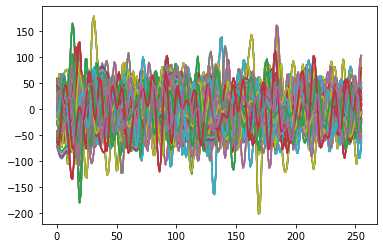

In [74]:
ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [7,10,12]
fs_synth = 256
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train_set = 6
removeDC = True
applyFilter = True
synth_power = 0
synth_noise = 0


gtrainarray = []
mtrainarray = []


for i in range(1,18):
    gaccarray = []
    maccarray = []
    for number_of_train in range(2,number_of_train_set+1):
        # data_file_all = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/1/decoding_data.txt")
        data_file_all = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\{n}\decoding_data.txt".format(n=i))
        test_7 = data_file_all[:256*20]
        test_10 = data_file_all[256*20:256*40]
        test_12 = data_file_all[256*40:256*60]

        print(len(test_7),len(test_10),len(test_12))

        # train_7 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/1/7hz_calibration.txt")
        train_7 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\{n}\7hz_calibration.txt".format(n=i))
        # train_10 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/1/10hz_calibration.txt")
        train_10 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\{n}\10hz_calibration.txt".format(n=i))
        # train_12 = load_array_data_float("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/1/12hz_calibration.txt")
        train_12 = load_array_data_float(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\{n}\12hz_calibration.txt".format(n=i))

#         print(len(train_7),len(train_10),len(train_12))

        data_file_7 = flatten([train_7[:fs_synth*number_of_train], test_7])
        data_file_10 = flatten([train_10[:fs_synth*number_of_train], test_10])
        data_file_12 = flatten([train_12[:fs_synth*number_of_train], test_12])

        values_7 = prepare_data(data_file_7, 7, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
        values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)
        values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

#         print(values_12.shape, values_10.shape, values_7.shape)

        data_packed = np.array([values_7, values_10, values_12])

#         print("Packed Data Shape:",data_packed.shape)

        a = [i for i in range(number_of_train,data_packed.shape[-1])]
        b = [i for i in range(number_of_train)]
        train_test_idxs = [[]]
        train_test_idxs[0].append(np.array(a))
        train_test_idxs[0].append(np.array(b))
    #     print(len(train_test_idxs))
    #     print((train_test_idxs[0]))
        gacc, macc, gf, mf, = test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)
        if i == 8 and number_of_train == 3:
            print("participant 8 gcca:", gf)
        if i == 16 and number_of_train == 2:
            print("participant 16 mset:", mf)
        gaccarray.append(gacc)
        maccarray.append(macc)
    gtrainarray.append(gaccarray)
    mtrainarray.append(maccarray)

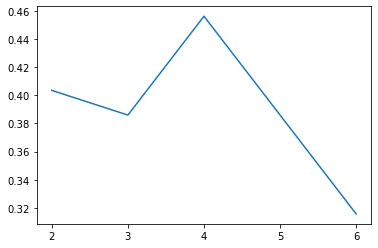

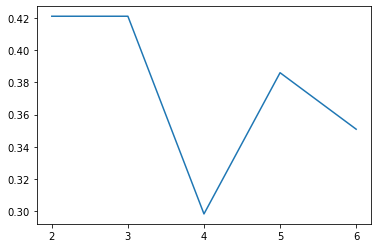

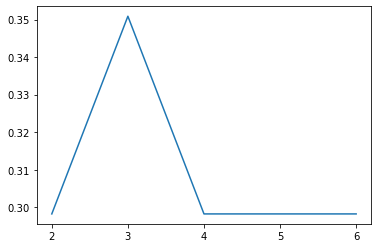

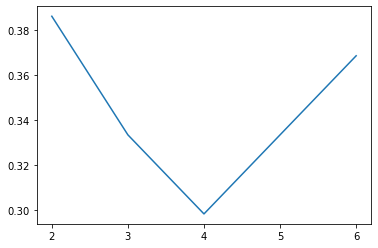

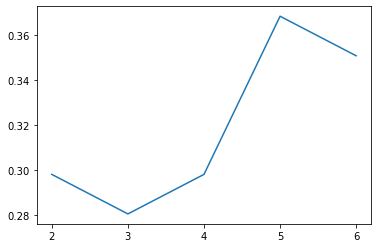

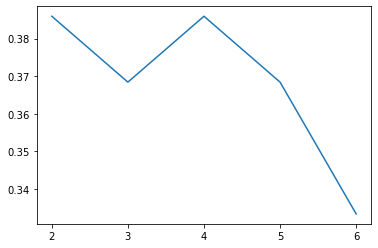

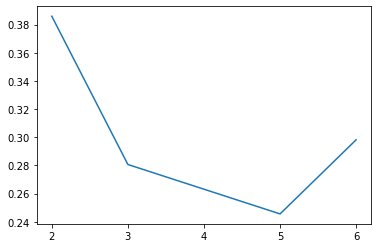

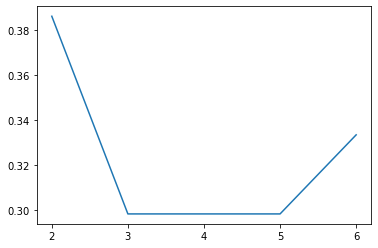

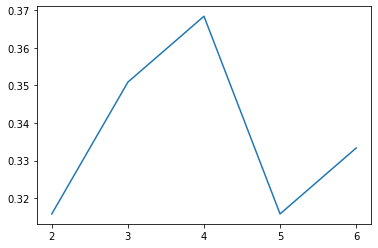

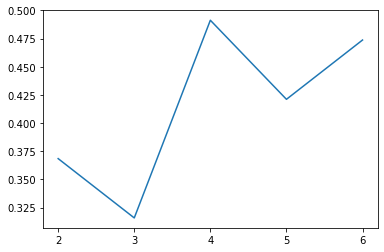

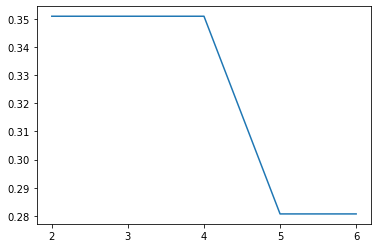

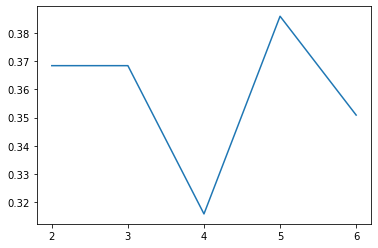

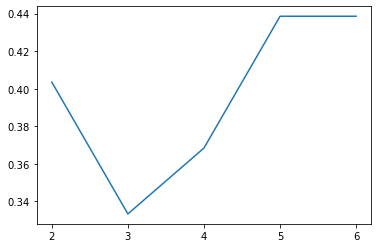

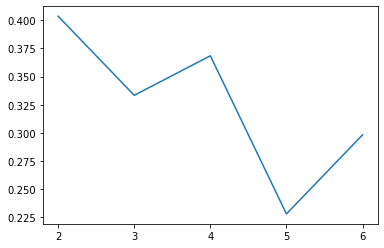

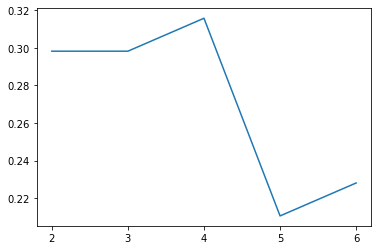

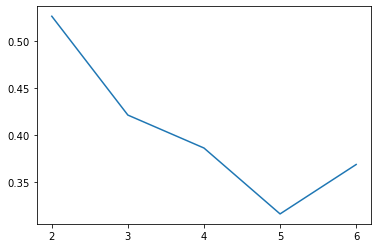

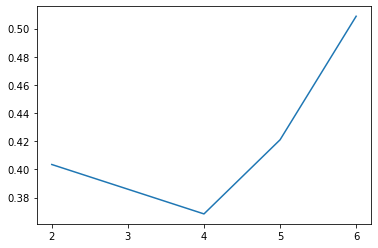

In [55]:
import matplotlib.pyplot as plt
for i in mtrainarray:
    plt.figure()
    plt.plot([2,3,4,5,6],i)
    plt.xticks(np.arange(min([2,3,4,5,6]), max([2,3,4,5,6])+1, 1.0))

In [69]:
maxs = []
mins = []
for i in gtrainarray:
    maxs.append(max(i))
    mins.append(min(i))

print(max(maxs))
print(min(mins))

maxs = []
mins = []
for i in mtrainarray:
    maxs.append(max(i))
    mins.append(min(i))

print(max(maxs))
print(min(mins))

0.5263157894736842
0.12280701754385964
0.5263157894736842
0.21052631578947367


In [72]:
gtrainarray

[[0.456140350877193,
  0.24561403508771926,
  0.3333333333333333,
  0.3859649122807018,
  0.3684210526315789],
 [0.5087719298245613,
  0.47368421052631576,
  0.3684210526315789,
  0.3508771929824561,
  0.47368421052631576],
 [0.2982456140350877,
  0.22807017543859645,
  0.21052631578947367,
  0.2982456140350877,
  0.2807017543859649],
 [0.456140350877193,
  0.3859649122807018,
  0.42105263157894735,
  0.3859649122807018,
  0.4035087719298245],
 [0.2982456140350877,
  0.31578947368421045,
  0.1929824561403509,
  0.2631578947368421,
  0.2631578947368421],
 [0.3508771929824561,
  0.24561403508771928,
  0.3684210526315789,
  0.3333333333333333,
  0.3859649122807018],
 [0.2982456140350877,
  0.31578947368421056,
  0.3157894736842105,
  0.2807017543859649,
  0.3333333333333333],
 [0.4561403508771929,
  0.5263157894736842,
  0.3859649122807018,
  0.31578947368421045,
  0.3859649122807018],
 [0.3333333333333333,
  0.2982456140350877,
  0.3333333333333333,
  0.31578947368421045,
  0.35087719298

In [60]:
import numpy as np

vals = {   2:[],
           3:[],
           4:[],
           5:[],
           6:[],
       }

for i in gtrainarray:
    vals[2].append(i[0])
    vals[3].append(i[1])
    vals[4].append(i[2])
    vals[5].append(i[3])
    vals[6].append(i[4])

print(np.mean(vals[2]))
print(np.mean(vals[3]))
print(np.mean(vals[4]))
print(np.mean(vals[5]))
print(np.mean(vals[6]))

print("\n")

vals = {   2:[],
           3:[],
           4:[],
           5:[],
           6:[],
       }

for i in mtrainarray:
    vals[2].append(i[0])
    vals[3].append(i[1])
    vals[4].append(i[2])
    vals[5].append(i[3])
    vals[6].append(i[4])

print(np.mean(vals[2]))
print(np.mean(vals[3]))
print(np.mean(vals[4]))
print(np.mean(vals[5]))
print(np.mean(vals[6]))

0.3519091847265221
0.3415892672858617
0.326109391124871
0.3178534571723426
0.34158926728586175


0.3766769865841073
0.3457172342621259
0.34881320949432404
0.33539731682146534
0.34881320949432404


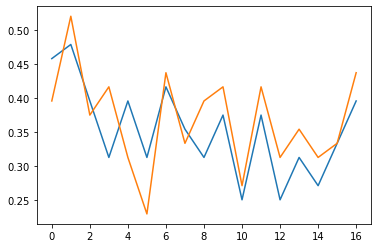

In [33]:
import matplotlib.pyplot as plt

plt.plot(gaccarray)
plt.plot(maccarray)

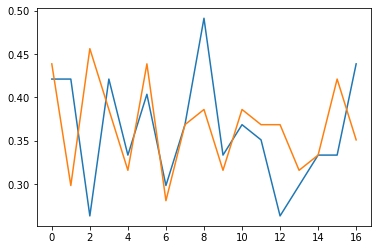

In [24]:
import matplotlib.pyplot as plt

plt.plot(gaccarray)
plt.plot(maccarray)